# Import Modules

In [1]:
import numpy as np
from fourrooms import Fourrooms
from IPython.display import clear_output
from aoaoc_classes import *
import matplotlib.pyplot as plt
from visualize import Visualization

# HyperParameters

In [2]:
# Replace the command line argparse
class Arguments:
    def __init__(self):
        # Numbers
        self.nepisodes=4000
        self.nruns=1
        self.nsteps=2000
        self.noptions=4
        
        # Learning Rates
        self.lr_term=0.1
        self.lr_intra=0.25
        self.lr_critic=0.5
        self.lr_critic_pseudo=0.5
        self.lr_criticA=0.5
        self.lr_criticA_pseudo=0.5
        self.lr_attend=0.02
        
        # Environment Parameters
        self.discount=0.99
        self.deterministic = False
        self.punishEachStep = False
        
        # Attention Parameters
        self.h_learn=True
        self.clipthres = 0.1
        self.stretchthres = 1.
        self.stretchstep = 1.
        
        # Distraction Parameters
        self.xi=1.
        self.n=0.5
        
        # Policy Parameters
        self.epsilon=1e-1
        self.temp=1.
        
        # Objective Parameters
        self.wo1 = 1.   #q
        self.wo2 = 2.    #cosim
        self.wo3 = 2.    #entropy
        self.wo4 = 5.    #size
        self.wo4p = 2
        
        # Randomness Parameters
        self.seed=2222
        self.seed_startstate=1111
        
        # Display Parameters
        self.showMap = False
        self.showAttention = False
        
        # Other Parameters
        self.baseline=True
        self.dc = 0.1
        
        
args = Arguments()

# Run

## Set up

In [3]:
rng = np.random.RandomState(args.seed)
env = Fourrooms(args.seed_startstate, args.punishEachStep, args.deterministic)
R = 50.

possible_next_goals = [68, 69, 70, 71, 72, 78, 79, 80, 81, 82, 88, 89, 90, 91, 92, 93, 99, 100, 101, 102, 103]

features = Tabular(env.observation_space)
nfeatures, nactions = len(features), env.action_space

viz = Visualization(env, args)

## Main loop

In [4]:
for run in range(args.nruns):
    # Set up classes
    policy_over_options = POO(rng, nfeatures, args)
    CoSimObj.reset()
    options = [Option(rng, nfeatures, nactions, args, R, policy_over_options, i) for i in range(args.noptions)]

    # Loop through games
    for episode in range(args.nepisodes):
        # Initial state
        return_per_episode = 0.0
        observation = env.reset()
        phi = features(observation)    
        option = policy_over_options.sample(phi)
        action = options[option].sample(phi)
        traject = [[phi,option],[phi,option],action]
        viz.resetMap(phi)

        # Reset record
        cumreward = 0.
        duration = 1
        option_switches = 0
        avgduration = 0.
        
        # Loop through frames in 1 game
        for step in range(args.nsteps):
            # Collect feedback from environment
            observation, reward, done, _ = env.step(action)
            phi = features(observation)
            return_per_episode += pow(args.discount,step)*reward
            
            # Render
            if args.showMap and episode % 100 == 99:
                clear_output(wait=True)
                viz.showMap(phi, option)

            # Store option index
            last_option = option
            
            # Check termination
            termination = options[option].terminate(phi, value=True)
            if options[option].terminate(phi):
                option = policy_over_options.sample(phi)
                option_switches += 1
                avgduration += (1./option_switches)*(duration - avgduration)
                duration = 1
        
            # Record into trajectory
            traject[0] = traject[1]
            traject[1] = [phi, option]
            traject[2] = action
            
            # Sample next action
            action = options[option].sample(phi)

            # Policy Evaluation + Policy Improvement
            baseline = policy_over_options.value(traject[0][0], traject[0][1], pseudo=True)
            advantage = policy_over_options.advantage(phi, last_option)
            options[last_option].update(traject, reward, done, phi, last_option, termination, baseline, advantage)
            policy_over_options.update(traject, reward, options[last_option].distract(reward,traject[2]), done, termination)
            
            # End of frame
            cumreward += options[last_option].distract(reward, traject[2])
            duration += 1
            if done:
                break
                
        # Attention graph
        if args.showAttention:
            clear_output(wait=True)
            viz.showAttention(options)

        print('Run {} episode {} steps {} cumreward {} avg. duration {} switches {}'.format(run, episode, step, cumreward, avgduration, option_switches))

Run 0 episode 0 steps 48 cumreward -494.53573216164847 avg. duration 3.08695652173913 switches 23
Run 0 episode 1 steps 7 cumreward -47.26751562581811 avg. duration 2.0 switches 5
Run 0 episode 2 steps 63 cumreward -707.5711848046443 avg. duration 2.7499999999999996 switches 36
Run 0 episode 3 steps 94 cumreward -1085.8333659264058 avg. duration 2.3188405797101446 switches 69
Run 0 episode 4 steps 460 cumreward -4304.133763917318 avg. duration 2.220159151193635 switches 377
Run 0 episode 5 steps 234 cumreward -1751.3286127586503 avg. duration 2.0934579439252348 switches 214
Run 0 episode 6 steps 22 cumreward -171.8734675189752 avg. duration 2.1578947368421058 switches 19
Run 0 episode 7 steps 341 cumreward -2230.485831886152 avg. duration 2.069620253164555 switches 316
Run 0 episode 8 steps 153 cumreward -919.1674538247523 avg. duration 2.077464788732396 switches 142
Run 0 episode 9 steps 1224 cumreward -3545.1660635825738 avg. duration 2.129151291512914 switches 1084
Run 0 episode 10 

Run 0 episode 88 steps 123 cumreward -47.378091614818196 avg. duration 2.1634615384615374 switches 104
Run 0 episode 89 steps 7 cumreward 45.892699415364596 avg. duration 1.8333333333333335 switches 6
Run 0 episode 90 steps 27 cumreward 31.517397371762268 avg. duration 2.083333333333334 switches 24
Run 0 episode 91 steps 187 cumreward -179.16150906747342 avg. duration 2.267123287671233 switches 146
Run 0 episode 92 steps 6 cumreward 46.793297187252726 avg. duration 1.8571428571428572 switches 7
Run 0 episode 93 steps 5 cumreward 45.90114361489621 avg. duration 2.3333333333333335 switches 3
Run 0 episode 94 steps 171 cumreward -129.25449075239965 avg. duration 2.25 switches 136
Run 0 episode 95 steps 134 cumreward -16.882660510990554 avg. duration 2.165217391304347 switches 115
Run 0 episode 96 steps 105 cumreward -62.82583333038904 avg. duration 2.2380952380952395 switches 84
Run 0 episode 97 steps 4 cumreward 46.82288476209126 avg. duration 1.8 switches 5
Run 0 episode 98 steps 86 cum

Run 0 episode 174 steps 212 cumreward 0.9611652830145587 avg. duration 2.233918128654972 switches 171
Run 0 episode 175 steps 8 cumreward 48.84029380370951 avg. duration 1.8888888888888888 switches 9
Run 0 episode 176 steps 25 cumreward 42.875757571065435 avg. duration 2.388888888888889 switches 18
Run 0 episode 177 steps 168 cumreward 17.049017715365814 avg. duration 2.166666666666667 switches 144
Run 0 episode 178 steps 210 cumreward 7.5467034762969405 avg. duration 2.222222222222223 switches 171
Run 0 episode 179 steps 18 cumreward 46.64530477493972 avg. duration 2.2142857142857144 switches 14
Run 0 episode 180 steps 44 cumreward 21.952377156943705 avg. duration 2.3333333333333335 switches 33
Run 0 episode 181 steps 330 cumreward -48.524776347266894 avg. duration 2.1913357400722018 switches 277
Run 0 episode 182 steps 73 cumreward 34.084553926702405 avg. duration 2.1587301587301586 switches 63
Run 0 episode 183 steps 9 cumreward 45.62245583727207 avg. duration 2.0 switches 8
Run 0 e

Run 0 episode 261 steps 16 cumreward 46.63837155930437 avg. duration 2.25 switches 12
Run 0 episode 262 steps 2 cumreward 49.67216131086746 avg. duration 1.0 switches 1
Run 0 episode 263 steps 27 cumreward 45.67412554436922 avg. duration 2.08 switches 25
Run 0 episode 264 steps 21 cumreward 46.32382547436068 avg. duration 2.111111111111111 switches 18
Run 0 episode 265 steps 45 cumreward 40.91401057581066 avg. duration 2.153846153846154 switches 39
Run 0 episode 266 steps 13 cumreward 46.27838732642768 avg. duration 2.1818181818181825 switches 11
Run 0 episode 267 steps 6 cumreward 49.116993259998154 avg. duration 1.8333333333333335 switches 6
Run 0 episode 268 steps 11 cumreward 47.604741092335104 avg. duration 2.0 switches 10
Run 0 episode 269 steps 22 cumreward 46.06733892497707 avg. duration 2.1052631578947376 switches 19
Run 0 episode 270 steps 51 cumreward 41.14332528542263 avg. duration 2.1363636363636367 switches 44
Run 0 episode 271 steps 155 cumreward 23.885653583294133 avg. 

Run 0 episode 345 steps 76 cumreward 39.534185931534765 avg. duration 2.2295081967213113 switches 61
Run 0 episode 346 steps 66 cumreward 37.56216239705638 avg. duration 2.137931034482758 switches 58
Run 0 episode 347 steps 3 cumreward 49.48073959666515 avg. duration 1.6666666666666667 switches 3
Run 0 episode 348 steps 12 cumreward 48.84683382263851 avg. duration 2.0 switches 11
Run 0 episode 349 steps 64 cumreward 40.068789384453694 avg. duration 2.0508474576271194 switches 59
Run 0 episode 350 steps 20 cumreward 46.41877627065573 avg. duration 2.0 switches 19
Run 0 episode 351 steps 12 cumreward 47.33800986047314 avg. duration 2.0 switches 11
Run 0 episode 352 steps 11 cumreward 47.73339690478228 avg. duration 2.0 switches 11
Run 0 episode 353 steps 29 cumreward 44.60666194667715 avg. duration 2.217391304347826 switches 23
Run 0 episode 354 steps 9 cumreward 47.95690454379497 avg. duration 1.9 switches 10
Run 0 episode 355 steps 128 cumreward 37.03516333006771 avg. duration 2.123893

Run 0 episode 436 steps 52 cumreward 44.22033940225176 avg. duration 2.083333333333333 switches 48
Run 0 episode 437 steps 32 cumreward 47.15376237928275 avg. duration 2.107142857142857 switches 28
Run 0 episode 438 steps 29 cumreward 47.02117393947839 avg. duration 2.119999999999999 switches 25
Run 0 episode 439 steps 10 cumreward 48.847581049302654 avg. duration 2.1250000000000004 switches 8
Run 0 episode 440 steps 27 cumreward 47.215683794575625 avg. duration 2.3000000000000007 switches 20
Run 0 episode 441 steps 31 cumreward 46.58122742266766 avg. duration 2.1481481481481484 switches 27
Run 0 episode 442 steps 22 cumreward 46.991442369279106 avg. duration 2.1052631578947367 switches 19
Run 0 episode 443 steps 5 cumreward 49.336909392720536 avg. duration 2.3333333333333335 switches 3
Run 0 episode 444 steps 12 cumreward 48.98140726323631 avg. duration 2.0 switches 10
Run 0 episode 445 steps 22 cumreward 46.93378272507971 avg. duration 2.1052631578947367 switches 19
Run 0 episode 446

Run 0 episode 523 steps 8 cumreward 49.15632368916019 avg. duration 1.875 switches 8
Run 0 episode 524 steps 16 cumreward 48.17133649148344 avg. duration 1.9333333333333331 switches 15
Run 0 episode 525 steps 47 cumreward 45.31130897498351 avg. duration 2.0222222222222226 switches 45
Run 0 episode 526 steps 3 cumreward 49.354004620230086 avg. duration 1.6666666666666667 switches 3
Run 0 episode 527 steps 3 cumreward 49.81285690559884 avg. duration 1.0 switches 1
Run 0 episode 528 steps 3 cumreward 49.49762716054937 avg. duration 1.75 switches 4
Run 0 episode 529 steps 6 cumreward 49.3233403717579 avg. duration 2.0 switches 5
Run 0 episode 530 steps 31 cumreward 47.2545165135854 avg. duration 2.0 switches 30
Run 0 episode 531 steps 2 cumreward 49.791389585157624 avg. duration 1.5 switches 2
Run 0 episode 532 steps 2 cumreward 49.75234424422769 avg. duration 1.5 switches 2
Run 0 episode 533 steps 9 cumreward 49.327858451767305 avg. duration 2.0 switches 9
Run 0 episode 534 steps 10 cumre

Run 0 episode 614 steps 101 cumreward 37.586458153155036 avg. duration 2.030927835051546 switches 97
Run 0 episode 615 steps 19 cumreward 48.53992146782938 avg. duration 2.2 switches 15
Run 0 episode 616 steps 19 cumreward 48.74249271323113 avg. duration 2.071428571428571 switches 14
Run 0 episode 617 steps 25 cumreward 47.98578205216399 avg. duration 1.9999999999999998 switches 24
Run 0 episode 618 steps 46 cumreward 45.210639185902615 avg. duration 2.0465116279069764 switches 43
Run 0 episode 619 steps 55 cumreward 44.63207998386904 avg. duration 2.018867924528302 switches 53
Run 0 episode 620 steps 29 cumreward 48.14512840866797 avg. duration 2.115384615384615 switches 26
Run 0 episode 621 steps 21 cumreward 48.616380115028015 avg. duration 2.2500000000000004 switches 16
Run 0 episode 622 steps 101 cumreward 40.08749540580982 avg. duration 2.0989010989010985 switches 91
Run 0 episode 623 steps 8 cumreward 49.34235775842579 avg. duration 1.8888888888888888 switches 9
Run 0 episode 62

Run 0 episode 700 steps 83 cumreward 42.26775580468255 avg. duration 2.078947368421053 switches 76
Run 0 episode 701 steps 25 cumreward 47.48227047530792 avg. duration 2.1904761904761902 switches 21
Run 0 episode 702 steps 42 cumreward 46.95502794894888 avg. duration 2.1714285714285717 switches 35
Run 0 episode 703 steps 8 cumreward 49.1389515942141 avg. duration 1.875 switches 8
Run 0 episode 704 steps 11 cumreward 48.84136292998055 avg. duration 2.375 switches 8
Run 0 episode 705 steps 24 cumreward 48.08247726993536 avg. duration 2.0454545454545454 switches 22
Run 0 episode 706 steps 24 cumreward 48.52565679996901 avg. duration 2.5333333333333337 switches 15
Run 0 episode 707 steps 5 cumreward 49.68052188883419 avg. duration 2.25 switches 4
Run 0 episode 708 steps 10 cumreward 49.2055100166862 avg. duration 2.2857142857142856 switches 7
Run 0 episode 709 steps 57 cumreward 45.526392407739905 avg. duration 2.1399999999999997 switches 50
Run 0 episode 710 steps 6 cumreward 49.688143340

Run 0 episode 789 steps 136 cumreward 41.28128161824496 avg. duration 2.0465116279069773 switches 129
Run 0 episode 790 steps 5 cumreward 49.284544484556456 avg. duration 1.8 switches 5
Run 0 episode 791 steps 72 cumreward 45.76804494084059 avg. duration 2.1093750000000004 switches 64
Run 0 episode 792 steps 14 cumreward 49.09237926230276 avg. duration 2.1818181818181825 switches 11
Run 0 episode 793 steps 34 cumreward 48.0373699559342 avg. duration 2.3200000000000003 switches 25
Run 0 episode 794 steps 24 cumreward 48.04040336257927 avg. duration 2.0952380952380953 switches 21
Run 0 episode 795 steps 21 cumreward 48.434611838342775 avg. duration 2.2352941176470593 switches 17
Run 0 episode 796 steps 10 cumreward 48.82416954807028 avg. duration 2.0 switches 10
Run 0 episode 797 steps 185 cumreward 37.8678908908056 avg. duration 2.051428571428571 switches 175
Run 0 episode 798 steps 33 cumreward 48.088171159690745 avg. duration 2.103448275862069 switches 29
Run 0 episode 799 steps 5 cum

Run 0 episode 875 steps 17 cumreward 49.265207159086515 avg. duration 2.230769230769231 switches 13
Run 0 episode 876 steps 9 cumreward 49.5518992437913 avg. duration 2.0 switches 8
Run 0 episode 877 steps 11 cumreward 49.2384402540291 avg. duration 2.2857142857142856 switches 7
Run 0 episode 878 steps 108 cumreward 42.85982870770507 avg. duration 2.1030927835051547 switches 97
Run 0 episode 879 steps 19 cumreward 48.82876322148904 avg. duration 2.125 switches 16
Run 0 episode 880 steps 22 cumreward 48.9798183022653 avg. duration 2.1578947368421053 switches 19
Run 0 episode 881 steps 41 cumreward 47.20428043035004 avg. duration 2.0789473684210527 switches 38
Run 0 episode 882 steps 16 cumreward 49.38865654124941 avg. duration 2.2307692307692313 switches 13
Run 0 episode 883 steps 19 cumreward 49.040144049787806 avg. duration 2.1250000000000004 switches 16
Run 0 episode 884 steps 2 cumreward 49.82434332239645 avg. duration 1.5 switches 2
Run 0 episode 885 steps 15 cumreward 49.085530470

Run 0 episode 966 steps 20 cumreward 48.77651075437644 avg. duration 2.176470588235294 switches 17
Run 0 episode 967 steps 13 cumreward 49.331877834028006 avg. duration 2.083333333333333 switches 12
Run 0 episode 968 steps 16 cumreward 49.43328745209253 avg. duration 2.25 switches 12
Run 0 episode 969 steps 23 cumreward 48.17586283662822 avg. duration 2.0 switches 22
Run 0 episode 970 steps 6 cumreward 49.753256345640374 avg. duration 1.8333333333333335 switches 6
Run 0 episode 971 steps 42 cumreward 48.24805715665992 avg. duration 2.025 switches 40
Run 0 episode 972 steps 46 cumreward 47.40084063663147 avg. duration 2.18421052631579 switches 38
Run 0 episode 973 steps 21 cumreward 49.013248362692856 avg. duration 2.25 switches 16
Run 0 episode 974 steps 22 cumreward 49.08237246598649 avg. duration 2.105263157894737 switches 19
Run 0 episode 975 steps 61 cumreward 46.79990672998021 avg. duration 2.03448275862069 switches 58
Run 0 episode 976 steps 49 cumreward 47.5064754503304 avg. dur

Run 0 episode 1052 steps 84 cumreward 45.988346874127856 avg. duration 2.077922077922078 switches 77
Run 0 episode 1053 steps 192 cumreward 39.355598982725866 avg. duration 2.061111111111109 switches 180
Run 0 episode 1054 steps 33 cumreward 48.17177029830667 avg. duration 2.0999999999999996 switches 30
Run 0 episode 1055 steps 33 cumreward 47.86046744875871 avg. duration 2.1034482758620685 switches 29
Run 0 episode 1056 steps 49 cumreward 47.158467966043375 avg. duration 2.297297297297298 switches 37
Run 0 episode 1057 steps 8 cumreward 49.71476925017631 avg. duration 2.166666666666667 switches 6
Run 0 episode 1058 steps 5 cumreward 49.81112398156744 avg. duration 2.0 switches 2
Run 0 episode 1059 steps 9 cumreward 49.60796147291067 avg. duration 2.2 switches 5
Run 0 episode 1060 steps 9 cumreward 49.67458880470856 avg. duration 2.6 switches 5
Run 0 episode 1061 steps 48 cumreward 46.9916748982984 avg. duration 2.146341463414634 switches 41
Run 0 episode 1062 steps 30 cumreward 48.148

Run 0 episode 1137 steps 13 cumreward 49.48760911203122 avg. duration 2.5 switches 8
Run 0 episode 1138 steps 29 cumreward 48.687976525741504 avg. duration 2.08 switches 25
Run 0 episode 1139 steps 8 cumreward 49.64806029107176 avg. duration 2.0 switches 7
Run 0 episode 1140 steps 29 cumreward 48.544010200373584 avg. duration 2.076923076923077 switches 26
Run 0 episode 1141 steps 6 cumreward 49.78966564620967 avg. duration 2.0 switches 5
Run 0 episode 1142 steps 44 cumreward 47.936414862270674 avg. duration 2.2647058823529416 switches 34
Run 0 episode 1143 steps 12 cumreward 49.400431475238754 avg. duration 2.090909090909091 switches 11
Run 0 episode 1144 steps 8 cumreward 49.730307313924335 avg. duration 2.4 switches 5
Run 0 episode 1145 steps 4 cumreward 49.85606486681726 avg. duration 2.0 switches 3
Run 0 episode 1146 steps 37 cumreward 48.15854926808319 avg. duration 2.090909090909091 switches 33
Run 0 episode 1147 steps 19 cumreward 49.31760343017581 avg. duration 2.28571428571428

Run 0 episode 1227 steps 91 cumreward 46.2516178408678 avg. duration 2.071428571428572 switches 84
Run 0 episode 1228 steps 19 cumreward 49.334605545463134 avg. duration 2.285714285714286 switches 14
Run 0 episode 1229 steps 17 cumreward 49.28882892203482 avg. duration 2.230769230769231 switches 13
Run 0 episode 1230 steps 33 cumreward 48.5808214422257 avg. duration 2.2799999999999994 switches 25
Run 0 episode 1231 steps 44 cumreward 48.20752130544189 avg. duration 2.3030303030303036 switches 33
Run 0 episode 1232 steps 31 cumreward 48.63189347149597 avg. duration 2.071428571428572 switches 28
Run 0 episode 1233 steps 39 cumreward 48.59338581502118 avg. duration 2.085714285714286 switches 35
Run 0 episode 1234 steps 3 cumreward 49.89720770708191 avg. duration 1.75 switches 4
Run 0 episode 1235 steps 18 cumreward 49.483799306068306 avg. duration 2.1333333333333333 switches 15
Run 0 episode 1236 steps 35 cumreward 48.68648022664408 avg. duration 2.1333333333333333 switches 30
Run 0 episo

Run 0 episode 1316 steps 53 cumreward 47.60963694998484 avg. duration 2.106382978723404 switches 47
Run 0 episode 1317 steps 0 cumreward 49.96985297295266 avg. duration 0.0 switches 0
Run 0 episode 1318 steps 27 cumreward 49.102700938259446 avg. duration 2.130434782608696 switches 23
Run 0 episode 1319 steps 5 cumreward 49.77476813946026 avg. duration 2.0 switches 5
Run 0 episode 1320 steps 45 cumreward 48.106785513873746 avg. duration 2.222222222222222 switches 36
Run 0 episode 1321 steps 181 cumreward 41.92985059800442 avg. duration 2.0591715976331364 switches 169
Run 0 episode 1322 steps 26 cumreward 49.13312976609428 avg. duration 2.190476190476191 switches 21
Run 0 episode 1323 steps 56 cumreward 48.07144298116562 avg. duration 2.122448979591837 switches 49
Run 0 episode 1324 steps 19 cumreward 49.10389119703514 avg. duration 2.0 switches 16
Run 0 episode 1325 steps 43 cumreward 48.56746826777622 avg. duration 2.1666666666666665 switches 36
Run 0 episode 1326 steps 1 cumreward 49.

Run 0 episode 1401 steps 78 cumreward 46.77579694554566 avg. duration 2.0694444444444438 switches 72
Run 0 episode 1402 steps 22 cumreward 49.30387749367607 avg. duration 2.375 switches 16
Run 0 episode 1403 steps 13 cumreward 49.65958975804133 avg. duration 2.5 switches 8
Run 0 episode 1404 steps 61 cumreward 47.452118680585166 avg. duration 2.0892857142857144 switches 56
Run 0 episode 1405 steps 22 cumreward 49.04038970073255 avg. duration 2.1578947368421053 switches 19
Run 0 episode 1406 steps 34 cumreward 48.60078255146707 avg. duration 1.9999999999999998 switches 33
Run 0 episode 1407 steps 14 cumreward 49.42703967272195 avg. duration 2.1818181818181825 switches 11
Run 0 episode 1408 steps 43 cumreward 48.34282747513591 avg. duration 2.05 switches 40
Run 0 episode 1409 steps 11 cumreward 49.65385343602802 avg. duration 2.25 switches 8
Run 0 episode 1410 steps 13 cumreward 49.68076839452697 avg. duration 2.5 switches 8
Run 0 episode 1411 steps 24 cumreward 49.06955318329033 avg. du

Run 0 episode 1490 steps 120 cumreward 45.87201334333303 avg. duration 2.0810810810810803 switches 111
Run 0 episode 1491 steps 16 cumreward 49.444657301638046 avg. duration 2.153846153846154 switches 13
Run 0 episode 1492 steps 5 cumreward 49.734819584930285 avg. duration 1.8 switches 5
Run 0 episode 1493 steps 94 cumreward 46.16735234182962 avg. duration 2.094117647058824 switches 85
Run 0 episode 1494 steps 34 cumreward 48.631276277033436 avg. duration 2.1379310344827585 switches 29
Run 0 episode 1495 steps 17 cumreward 49.46962137185701 avg. duration 2.142857142857143 switches 14
Run 0 episode 1496 steps 20 cumreward 49.353559297211355 avg. duration 2.0 switches 19
Run 0 episode 1497 steps 52 cumreward 48.39633218316507 avg. duration 2.083333333333333 switches 48
Run 0 episode 1498 steps 64 cumreward 47.723407034541125 avg. duration 2.1272727272727265 switches 55
Run 0 episode 1499 steps 43 cumreward 48.557176445616356 avg. duration 2.0500000000000003 switches 40
Run 0 episode 1500

Run 0 episode 1577 steps 20 cumreward 49.25363316176316 avg. duration 2.1176470588235303 switches 17
Run 0 episode 1578 steps 4 cumreward 49.71995604918307 avg. duration 1.75 switches 4
Run 0 episode 1579 steps 42 cumreward 48.57692136303361 avg. duration 2.1388888888888884 switches 36
Run 0 episode 1580 steps 9 cumreward 49.75407515938239 avg. duration 2.1428571428571432 switches 7
Run 0 episode 1581 steps 13 cumreward 49.607771242204684 avg. duration 2.7142857142857144 switches 7
Run 0 episode 1582 steps 66 cumreward 47.141087253521995 avg. duration 2.015625 switches 64
Run 0 episode 1583 steps 30 cumreward 49.05784576767546 avg. duration 2.0740740740740744 switches 27
Run 0 episode 1584 steps 138 cumreward 45.05601207831615 avg. duration 2.0952380952380967 switches 126
Run 0 episode 1585 steps 11 cumreward 49.34395717141297 avg. duration 2.1111111111111116 switches 9
Run 0 episode 1586 steps 41 cumreward 48.90009674330241 avg. duration 1.9756097560975607 switches 41
Run 0 episode 15

Run 0 episode 1663 steps 39 cumreward 48.70657610549051 avg. duration 2.0555555555555554 switches 36
Run 0 episode 1664 steps 28 cumreward 48.918991392735805 avg. duration 2.124999999999999 switches 24
Run 0 episode 1665 steps 25 cumreward 49.06288774014761 avg. duration 2.2 switches 20
Run 0 episode 1666 steps 39 cumreward 48.16488394803819 avg. duration 1.9999999999999998 switches 38
Run 0 episode 1667 steps 5 cumreward 49.83380998377982 avg. duration 2.0 switches 4
Run 0 episode 1668 steps 6 cumreward 49.84622525569468 avg. duration 2.6666666666666665 switches 3
Run 0 episode 1669 steps 9 cumreward 49.79075190437998 avg. duration 2.0 switches 8
Run 0 episode 1670 steps 10 cumreward 49.75836056952493 avg. duration 2.5 switches 6
Run 0 episode 1671 steps 2 cumreward 49.90599563924378 avg. duration 1.5 switches 2
Run 0 episode 1672 steps 44 cumreward 48.16991157705409 avg. duration 1.9999999999999998 switches 43
Run 0 episode 1673 steps 5 cumreward 49.874756711922785 avg. duration 1.8 

Run 0 episode 1752 steps 28 cumreward 49.37852394671969 avg. duration 2.5000000000000004 switches 18
Run 0 episode 1753 steps 12 cumreward 49.67008621337763 avg. duration 2.2222222222222223 switches 9
Run 0 episode 1754 steps 30 cumreward 49.13062483515145 avg. duration 2.1153846153846145 switches 26
Run 0 episode 1755 steps 17 cumreward 49.27895879891979 avg. duration 2.0 switches 16
Run 0 episode 1756 steps 84 cumreward 47.61618783868504 avg. duration 2.0374999999999996 switches 80
Run 0 episode 1757 steps 4 cumreward 49.84237823942366 avg. duration 2.0 switches 3
Run 0 episode 1758 steps 16 cumreward 49.449064932922816 avg. duration 2.25 switches 12
Run 0 episode 1759 steps 36 cumreward 48.63459788122464 avg. duration 2.0937500000000004 switches 32
Run 0 episode 1760 steps 10 cumreward 49.75837710381348 avg. duration 2.0 switches 9
Run 0 episode 1761 steps 33 cumreward 49.114022700593665 avg. duration 2.103448275862069 switches 29
Run 0 episode 1762 steps 19 cumreward 49.49673263925

Run 0 episode 1842 steps 41 cumreward 48.89419225143613 avg. duration 2.1428571428571432 switches 35
Run 0 episode 1843 steps 36 cumreward 48.93033972953621 avg. duration 2.0294117647058822 switches 34
Run 0 episode 1844 steps 12 cumreward 49.7561534207325 avg. duration 2.0 switches 11
Run 0 episode 1845 steps 21 cumreward 49.50527165861856 avg. duration 2.052631578947368 switches 19
Run 0 episode 1846 steps 42 cumreward 48.834023561636606 avg. duration 2.108108108108108 switches 37
Run 0 episode 1847 steps 40 cumreward 48.874387733016995 avg. duration 2.1764705882352944 switches 34
Run 0 episode 1848 steps 29 cumreward 49.267706632110446 avg. duration 2.2727272727272734 switches 22
Run 0 episode 1849 steps 9 cumreward 49.722146285904266 avg. duration 2.1428571428571432 switches 7
Run 0 episode 1850 steps 71 cumreward 48.122570601170764 avg. duration 2.075757575757576 switches 66
Run 0 episode 1851 steps 25 cumreward 49.397938464172285 avg. duration 2.2631578947368416 switches 19
Run 0

Run 0 episode 1929 steps 124 cumreward 45.69090583507491 avg. duration 2.0603448275862077 switches 116
Run 0 episode 1930 steps 19 cumreward 49.5345267453345 avg. duration 2.285714285714286 switches 14
Run 0 episode 1931 steps 48 cumreward 48.60429497611127 avg. duration 2.093023255813953 switches 43
Run 0 episode 1932 steps 16 cumreward 49.627003250458756 avg. duration 2.0714285714285716 switches 14
Run 0 episode 1933 steps 12 cumreward 49.725918128840526 avg. duration 2.2000000000000006 switches 10
Run 0 episode 1934 steps 126 cumreward 45.33024145809194 avg. duration 2.0683760683760686 switches 117
Run 0 episode 1935 steps 5 cumreward 49.892374442743865 avg. duration 2.3333333333333335 switches 3
Run 0 episode 1936 steps 11 cumreward 49.71698180316259 avg. duration 2.111111111111111 switches 9
Run 0 episode 1937 steps 120 cumreward 45.281681243280936 avg. duration 2.0258620689655165 switches 116
Run 0 episode 1938 steps 1 cumreward 49.91165326197432 avg. duration 1.0 switches 1
Run 

Run 0 episode 2014 steps 79 cumreward 47.90055581208504 avg. duration 2.1304347826086962 switches 69
Run 0 episode 2015 steps 6 cumreward 49.876768307399 avg. duration 2.25 switches 4
Run 0 episode 2016 steps 11 cumreward 49.70673469307271 avg. duration 2.2500000000000004 switches 8
Run 0 episode 2017 steps 47 cumreward 48.639567431977184 avg. duration 2.0952380952380962 switches 42
Run 0 episode 2018 steps 37 cumreward 48.879262190388644 avg. duration 2.1935483870967745 switches 31
Run 0 episode 2019 steps 10 cumreward 49.66844761934519 avg. duration 2.1250000000000004 switches 8
Run 0 episode 2020 steps 34 cumreward 49.0593117940561 avg. duration 2.1000000000000005 switches 30
Run 0 episode 2021 steps 40 cumreward 48.867939834652816 avg. duration 2.1470588235294126 switches 34
Run 0 episode 2022 steps 191 cumreward 43.18603450224708 avg. duration 2.043956043956045 switches 182
Run 0 episode 2023 steps 102 cumreward 46.92972351565422 avg. duration 2.052083333333333 switches 96
Run 0 e

Run 0 episode 2105 steps 48 cumreward 48.85268291160651 avg. duration 2.0444444444444434 switches 45
Run 0 episode 2106 steps 3 cumreward 49.93875672169668 avg. duration 1.6666666666666667 switches 3
Run 0 episode 2107 steps 36 cumreward 48.98127813430759 avg. duration 2.0625 switches 32
Run 0 episode 2108 steps 58 cumreward 48.27644708318793 avg. duration 2.036363636363636 switches 55
Run 0 episode 2109 steps 28 cumreward 49.33540526695247 avg. duration 2.08 switches 25
Run 0 episode 2110 steps 2 cumreward 49.9504473118719 avg. duration 1.0 switches 1
Run 0 episode 2111 steps 71 cumreward 48.094727335770656 avg. duration 2.1111111111111116 switches 63
Run 0 episode 2112 steps 10 cumreward 49.70495150229898 avg. duration 2.2857142857142856 switches 7
Run 0 episode 2113 steps 2 cumreward 49.95050597976998 avg. duration 1.5 switches 2
Run 0 episode 2114 steps 9 cumreward 49.7982495198953 avg. duration 2.4 switches 5
Run 0 episode 2115 steps 22 cumreward 49.49549854229211 avg. duration 2.

Run 0 episode 2196 steps 27 cumreward 49.24756652281742 avg. duration 2.181818181818182 switches 22
Run 0 episode 2197 steps 32 cumreward 49.297644773094284 avg. duration 2.24 switches 25
Run 0 episode 2198 steps 18 cumreward 49.57128308506364 avg. duration 2.0625 switches 16
Run 0 episode 2199 steps 34 cumreward 49.04708891931552 avg. duration 2.103448275862069 switches 29
Run 0 episode 2200 steps 5 cumreward 49.73537193687694 avg. duration 2.0 switches 4
Run 0 episode 2201 steps 11 cumreward 49.66774311373394 avg. duration 2.1111111111111116 switches 9
Run 0 episode 2202 steps 25 cumreward 49.35896235729698 avg. duration 2.263157894736842 switches 19
Run 0 episode 2203 steps 35 cumreward 48.6947289531956 avg. duration 2.0625 switches 32
Run 0 episode 2204 steps 7 cumreward 49.86692207518471 avg. duration 2.4 switches 5
Run 0 episode 2205 steps 13 cumreward 49.69490274548448 avg. duration 2.0 switches 12
Run 0 episode 2206 steps 20 cumreward 49.42982614248301 avg. duration 2.357142857

Run 0 episode 2286 steps 12 cumreward 49.720909520091 avg. duration 2.2222222222222223 switches 9
Run 0 episode 2287 steps 13 cumreward 49.70634992450523 avg. duration 2.2 switches 10
Run 0 episode 2288 steps 3 cumreward 49.941586804237645 avg. duration 2.0 switches 2
Run 0 episode 2289 steps 15 cumreward 49.47894593464364 avg. duration 2.071428571428571 switches 14
Run 0 episode 2290 steps 6 cumreward 49.733501115072286 avg. duration 1.8333333333333335 switches 6
Run 0 episode 2291 steps 16 cumreward 49.61992205031248 avg. duration 2.5 switches 10
Run 0 episode 2292 steps 32 cumreward 48.92175561878833 avg. duration 2.192307692307692 switches 26
Run 0 episode 2293 steps 27 cumreward 49.253306657681904 avg. duration 2.2380952380952377 switches 21
Run 0 episode 2294 steps 12 cumreward 49.77386903031401 avg. duration 2.2222222222222228 switches 9
Run 0 episode 2295 steps 9 cumreward 49.8402054960892 avg. duration 2.0 switches 8
Run 0 episode 2296 steps 50 cumreward 48.41935166470248 avg.

Run 0 episode 2373 steps 70 cumreward 48.21734680884213 avg. duration 2.0454545454545454 switches 66
Run 0 episode 2374 steps 27 cumreward 49.37722253531496 avg. duration 2.0 switches 26
Run 0 episode 2375 steps 30 cumreward 49.25192658618767 avg. duration 2.4 switches 20
Run 0 episode 2376 steps 6 cumreward 49.840633978440216 avg. duration 2.25 switches 4
Run 0 episode 2377 steps 25 cumreward 49.511305267016006 avg. duration 2.210526315789474 switches 19
Run 0 episode 2378 steps 9 cumreward 49.78025734366112 avg. duration 2.333333333333333 switches 6
Run 0 episode 2379 steps 35 cumreward 49.042702590905314 avg. duration 2.129032258064516 switches 31
Run 0 episode 2380 steps 2 cumreward 49.94910058491064 avg. duration 1.5 switches 2
Run 0 episode 2381 steps 11 cumreward 49.7345677160935 avg. duration 2.428571428571429 switches 7
Run 0 episode 2382 steps 14 cumreward 49.74113911438766 avg. duration 2.3000000000000003 switches 10
Run 0 episode 2383 steps 0 cumreward 49.98278338474529 avg

Run 0 episode 2464 steps 71 cumreward 48.46651115513853 avg. duration 2.044776119402985 switches 67
Run 0 episode 2465 steps 6 cumreward 49.87378601775949 avg. duration 1.8333333333333335 switches 6
Run 0 episode 2466 steps 114 cumreward 47.179108067087 avg. duration 2.0865384615384617 switches 104
Run 0 episode 2467 steps 17 cumreward 49.714681472294515 avg. duration 2.3333333333333335 switches 12
Run 0 episode 2468 steps 90 cumreward 47.56780928665313 avg. duration 2.047058823529412 switches 85
Run 0 episode 2469 steps 10 cumreward 49.767425175903526 avg. duration 2.2857142857142856 switches 7
Run 0 episode 2470 steps 16 cumreward 49.68818693860723 avg. duration 2.3636363636363638 switches 11
Run 0 episode 2471 steps 16 cumreward 49.65315305949331 avg. duration 2.071428571428571 switches 14
Run 0 episode 2472 steps 2 cumreward 49.95625126067183 avg. duration 1.5 switches 2
Run 0 episode 2473 steps 15 cumreward 49.64841741526795 avg. duration 2.0769230769230766 switches 13
Run 0 episo

Run 0 episode 2555 steps 13 cumreward 49.75080434894417 avg. duration 2.2000000000000006 switches 10
Run 0 episode 2556 steps 31 cumreward 49.32863703734871 avg. duration 2.111111111111111 switches 27
Run 0 episode 2557 steps 9 cumreward 49.813784169626416 avg. duration 2.0 switches 8
Run 0 episode 2558 steps 3 cumreward 49.941945160201094 avg. duration 2.0 switches 2
Run 0 episode 2559 steps 30 cumreward 49.422448879348124 avg. duration 2.2608695652173916 switches 23
Run 0 episode 2560 steps 16 cumreward 49.6752664147904 avg. duration 2.250000000000001 switches 12
Run 0 episode 2561 steps 25 cumreward 49.36350173889402 avg. duration 2.090909090909091 switches 22
Run 0 episode 2562 steps 19 cumreward 49.635850966250715 avg. duration 2.5 switches 12
Run 0 episode 2563 steps 21 cumreward 49.597705425706756 avg. duration 2.1764705882352944 switches 17
Run 0 episode 2564 steps 33 cumreward 49.27775768301882 avg. duration 1.9696969696969693 switches 33
Run 0 episode 2565 steps 12 cumreward 

Run 0 episode 2642 steps 46 cumreward 48.843783667969646 avg. duration 2.189189189189189 switches 37
Run 0 episode 2643 steps 30 cumreward 49.3514175696318 avg. duration 2.111111111111111 switches 27
Run 0 episode 2644 steps 36 cumreward 49.16166390100882 avg. duration 2.09375 switches 32
Run 0 episode 2645 steps 7 cumreward 49.888055014157274 avg. duration 2.5 switches 4
Run 0 episode 2646 steps 15 cumreward 49.67519437324967 avg. duration 2.0 switches 14
Run 0 episode 2647 steps 29 cumreward 49.32422206099406 avg. duration 2.076923076923077 switches 26
Run 0 episode 2648 steps 63 cumreward 48.68070175940497 avg. duration 2.06896551724138 switches 58
Run 0 episode 2649 steps 23 cumreward 49.44080383036819 avg. duration 2.05 switches 20
Run 0 episode 2650 steps 40 cumreward 49.036603614050684 avg. duration 2.054054054054054 switches 37
Run 0 episode 2651 steps 29 cumreward 49.53239118545565 avg. duration 2.272727272727273 switches 22
Run 0 episode 2652 steps 78 cumreward 48.16797246188

Run 0 episode 2729 steps 15 cumreward 49.786669023691275 avg. duration 2.272727272727273 switches 11
Run 0 episode 2730 steps 7 cumreward 49.86719029286029 avg. duration 1.8571428571428572 switches 7
Run 0 episode 2731 steps 67 cumreward 48.64454957284919 avg. duration 2.11864406779661 switches 59
Run 0 episode 2732 steps 48 cumreward 48.72197619815023 avg. duration 2.0444444444444443 switches 45
Run 0 episode 2733 steps 5 cumreward 49.900618754775174 avg. duration 1.8 switches 5
Run 0 episode 2734 steps 106 cumreward 46.90143319011604 avg. duration 2.0096153846153846 switches 104
Run 0 episode 2735 steps 45 cumreward 49.10530557640696 avg. duration 2.1282051282051277 switches 39
Run 0 episode 2736 steps 35 cumreward 49.46798006395691 avg. duration 2.1333333333333333 switches 30
Run 0 episode 2737 steps 15 cumreward 49.78497074240251 avg. duration 2.1666666666666674 switches 12
Run 0 episode 2738 steps 166 cumreward 45.325115928157025 avg. duration 2.037735849056603 switches 159
Run 0 

Run 0 episode 2820 steps 103 cumreward 47.14731572132046 avg. duration 2.0515463917525785 switches 97
Run 0 episode 2821 steps 4 cumreward 49.936337433698796 avg. duration 1.6666666666666667 switches 3
Run 0 episode 2822 steps 21 cumreward 49.66115966104654 avg. duration 2.4000000000000004 switches 15
Run 0 episode 2823 steps 3 cumreward 49.925498933493216 avg. duration 1.6666666666666667 switches 3
Run 0 episode 2824 steps 20 cumreward 49.61657651077428 avg. duration 2.1875 switches 16
Run 0 episode 2825 steps 33 cumreward 49.4199799058382 avg. duration 2.1034482758620685 switches 29
Run 0 episode 2826 steps 50 cumreward 48.92574215387219 avg. duration 2.139534883720929 switches 43
Run 0 episode 2827 steps 28 cumreward 49.29532832915785 avg. duration 2.3499999999999996 switches 20
Run 0 episode 2828 steps 27 cumreward 49.43549864114192 avg. duration 2.2857142857142856 switches 21
Run 0 episode 2829 steps 11 cumreward 49.71351466284677 avg. duration 2.2500000000000004 switches 8
Run 0 

Run 0 episode 2905 steps 38 cumreward 49.26547858441533 avg. duration 2.1562500000000004 switches 32
Run 0 episode 2906 steps 3 cumreward 49.92736299951058 avg. duration 1.6666666666666667 switches 3
Run 0 episode 2907 steps 5 cumreward 49.8915591491024 avg. duration 2.0 switches 4
Run 0 episode 2908 steps 49 cumreward 49.06720134357239 avg. duration 2.068181818181818 switches 44
Run 0 episode 2909 steps 51 cumreward 49.023740233378135 avg. duration 2.08695652173913 switches 46
Run 0 episode 2910 steps 8 cumreward 49.77203930295802 avg. duration 2.0 switches 7
Run 0 episode 2911 steps 28 cumreward 49.490787644242786 avg. duration 2.173913043478261 switches 23
Run 0 episode 2912 steps 16 cumreward 49.669069207922966 avg. duration 1.9374999999999998 switches 16
Run 0 episode 2913 steps 56 cumreward 48.641907906820904 avg. duration 2.0784313725490198 switches 51
Run 0 episode 2914 steps 7 cumreward 49.82539431064682 avg. duration 2.0 switches 6
Run 0 episode 2915 steps 1 cumreward 49.9400

Run 0 episode 2993 steps 36 cumreward 49.32945293471348 avg. duration 2.1666666666666665 switches 30
Run 0 episode 2994 steps 22 cumreward 49.6135439004073 avg. duration 2.3125 switches 16
Run 0 episode 2995 steps 207 cumreward 45.250487534315944 avg. duration 2.0048780487804887 switches 205
Run 0 episode 2996 steps 28 cumreward 49.43252870427342 avg. duration 2.125 switches 24
Run 0 episode 2997 steps 31 cumreward 49.35339026044236 avg. duration 2.0344827586206895 switches 29
Run 0 episode 2998 steps 5 cumreward 49.89481190209536 avg. duration 2.0 switches 4
Run 0 episode 2999 steps 30 cumreward 49.422248100676065 avg. duration 2.1111111111111103 switches 27
Run 0 episode 3000 steps 19 cumreward 49.623434426510904 avg. duration 1.9999999999999998 switches 18
Run 0 episode 3001 steps 14 cumreward 49.68360893855754 avg. duration 2.1818181818181825 switches 11
Run 0 episode 3002 steps 8 cumreward 49.71012501086714 avg. duration 2.0 switches 7
Run 0 episode 3003 steps 9 cumreward 49.85483

Run 0 episode 3079 steps 33 cumreward 49.239609657234325 avg. duration 2.0666666666666664 switches 30
Run 0 episode 3080 steps 26 cumreward 49.627740630312694 avg. duration 2.31578947368421 switches 19
Run 0 episode 3081 steps 19 cumreward 49.73557076747633 avg. duration 2.357142857142857 switches 14
Run 0 episode 3082 steps 3 cumreward 49.95267477857703 avg. duration 2.0 switches 2
Run 0 episode 3083 steps 18 cumreward 49.7055249946908 avg. duration 2.307692307692308 switches 13
Run 0 episode 3084 steps 19 cumreward 49.69712597910882 avg. duration 2.3333333333333335 switches 12
Run 0 episode 3085 steps 30 cumreward 49.28756738738957 avg. duration 2.0740740740740744 switches 27
Run 0 episode 3086 steps 2 cumreward 49.9144427992594 avg. duration 1.5 switches 2
Run 0 episode 3087 steps 6 cumreward 49.915249479624435 avg. duration 2.6666666666666665 switches 3
Run 0 episode 3088 steps 31 cumreward 49.4376421453167 avg. duration 2.2499999999999996 switches 24
Run 0 episode 3089 steps 14 cu

Run 0 episode 3165 steps 23 cumreward 49.59029367456498 avg. duration 2.1578947368421053 switches 19
Run 0 episode 3166 steps 2 cumreward 49.966395735659425 avg. duration 1.5 switches 2
Run 0 episode 3167 steps 62 cumreward 48.89301025154887 avg. duration 2.2156862745098045 switches 51
Run 0 episode 3168 steps 11 cumreward 49.776284016882485 avg. duration 2.6666666666666665 switches 6
Run 0 episode 3169 steps 25 cumreward 49.586781288500816 avg. duration 2.142857142857143 switches 21
Run 0 episode 3170 steps 33 cumreward 49.3325384055502 avg. duration 2.0666666666666664 switches 30
Run 0 episode 3171 steps 24 cumreward 49.510873696255054 avg. duration 2.0952380952380953 switches 21
Run 0 episode 3172 steps 36 cumreward 49.35288151257209 avg. duration 2.0937499999999996 switches 32
Run 0 episode 3173 steps 15 cumreward 49.731394326873335 avg. duration 2.4000000000000004 switches 10
Run 0 episode 3174 steps 5 cumreward 49.83681819300288 avg. duration 1.8 switches 5
Run 0 episode 3175 ste

Run 0 episode 3253 steps 38 cumreward 49.15561685861482 avg. duration 2.057142857142857 switches 35
Run 0 episode 3254 steps 10 cumreward 49.843737543763275 avg. duration 2.2857142857142856 switches 7
Run 0 episode 3255 steps 30 cumreward 49.506436592038 avg. duration 2.08 switches 25
Run 0 episode 3256 steps 6 cumreward 49.91768420887071 avg. duration 2.6666666666666665 switches 3
Run 0 episode 3257 steps 14 cumreward 49.82704824533027 avg. duration 2.4444444444444446 switches 9
Run 0 episode 3258 steps 32 cumreward 49.51620295475725 avg. duration 2.4761904761904767 switches 21
Run 0 episode 3259 steps 16 cumreward 49.68332542760915 avg. duration 2.0 switches 15
Run 0 episode 3260 steps 38 cumreward 49.343305145973616 avg. duration 2.1176470588235294 switches 34
Run 0 episode 3261 steps 58 cumreward 49.02927801172575 avg. duration 2.1399999999999997 switches 50
Run 0 episode 3262 steps 28 cumreward 49.57782621325264 avg. duration 2.1363636363636362 switches 22
Run 0 episode 3263 steps

Run 0 episode 3340 steps 64 cumreward 48.86841106966351 avg. duration 2.0161290322580645 switches 62
Run 0 episode 3341 steps 12 cumreward 49.702769569052904 avg. duration 2.2222222222222228 switches 9
Run 0 episode 3342 steps 87 cumreward 48.33527255707896 avg. duration 2.131578947368422 switches 76
Run 0 episode 3343 steps 35 cumreward 49.39953147328062 avg. duration 2.230769230769231 switches 26
Run 0 episode 3344 steps 9 cumreward 49.75500170945363 avg. duration 2.1428571428571432 switches 7
Run 0 episode 3345 steps 13 cumreward 49.79208252112504 avg. duration 2.333333333333334 switches 9
Run 0 episode 3346 steps 36 cumreward 49.318023547206955 avg. duration 2.129032258064516 switches 31
Run 0 episode 3347 steps 2 cumreward 49.96793439396267 avg. duration 2.0 switches 1
Run 0 episode 3348 steps 5 cumreward 49.931501550134435 avg. duration 3.0 switches 2
Run 0 episode 3349 steps 40 cumreward 49.340921798687134 avg. duration 2.054054054054054 switches 37
Run 0 episode 3350 steps 63 c

Run 0 episode 3431 steps 25 cumreward 49.47069936212531 avg. duration 2.263157894736842 switches 19
Run 0 episode 3432 steps 11 cumreward 49.816229088469605 avg. duration 2.666666666666667 switches 6
Run 0 episode 3433 steps 23 cumreward 49.67099580306834 avg. duration 2.1578947368421058 switches 19
Run 0 episode 3434 steps 15 cumreward 49.771820564581056 avg. duration 2.272727272727273 switches 11
Run 0 episode 3435 steps 2 cumreward 49.968691444935494 avg. duration 2.0 switches 1
Run 0 episode 3436 steps 63 cumreward 48.99126033754741 avg. duration 2.086206896551724 switches 58
Run 0 episode 3437 steps 12 cumreward 49.682504223570845 avg. duration 2.1000000000000005 switches 10
Run 0 episode 3438 steps 64 cumreward 48.98576521009156 avg. duration 2.0500000000000003 switches 60
Run 0 episode 3439 steps 26 cumreward 49.617810847873784 avg. duration 2.181818181818182 switches 22
Run 0 episode 3440 steps 39 cumreward 49.24772072324319 avg. duration 2.1515151515151514 switches 33
Run 0 ep

Run 0 episode 3516 steps 16 cumreward 49.72869563405593 avg. duration 2.0769230769230766 switches 13
Run 0 episode 3517 steps 6 cumreward 49.8673367819588 avg. duration 1.8333333333333335 switches 6
Run 0 episode 3518 steps 12 cumreward 49.83060037228467 avg. duration 2.0 switches 11
Run 0 episode 3519 steps 5 cumreward 49.935169981867986 avg. duration 1.8333333333333335 switches 6
Run 0 episode 3520 steps 40 cumreward 49.27597329686538 avg. duration 2.117647058823529 switches 34
Run 0 episode 3521 steps 164 cumreward 47.06853166028409 avg. duration 2.0187500000000003 switches 160
Run 0 episode 3522 steps 6 cumreward 49.865796138766704 avg. duration 1.8333333333333335 switches 6
Run 0 episode 3523 steps 4 cumreward 49.94635195239286 avg. duration 1.75 switches 4
Run 0 episode 3524 steps 10 cumreward 49.82110418667314 avg. duration 1.9 switches 10
Run 0 episode 3525 steps 10 cumreward 49.88101473374606 avg. duration 2.0 switches 9
Run 0 episode 3526 steps 10 cumreward 49.85610089067718 

Run 0 episode 3611 steps 86 cumreward 48.17961693999686 avg. duration 2.0493827160493825 switches 81
Run 0 episode 3612 steps 34 cumreward 49.46872018963895 avg. duration 2.1071428571428568 switches 28
Run 0 episode 3613 steps 2 cumreward 49.95345192704215 avg. duration 1.5 switches 2
Run 0 episode 3614 steps 21 cumreward 49.654595763131205 avg. duration 2.176470588235294 switches 17
Run 0 episode 3615 steps 20 cumreward 49.737779521595456 avg. duration 2.1176470588235294 switches 17
Run 0 episode 3616 steps 8 cumreward 49.86265351070018 avg. duration 2.0 switches 5
Run 0 episode 3617 steps 12 cumreward 49.79247855347025 avg. duration 1.9166666666666665 switches 12
Run 0 episode 3618 steps 33 cumreward 49.51801948331342 avg. duration 2.2222222222222223 switches 27
Run 0 episode 3619 steps 12 cumreward 49.775265138940064 avg. duration 2.1 switches 10
Run 0 episode 3620 steps 7 cumreward 49.83181054369348 avg. duration 1.8571428571428572 switches 7
Run 0 episode 3621 steps 11 cumreward 4

Run 0 episode 3697 steps 195 cumreward 46.325056413933304 avg. duration 2.0543478260869543 switches 184
Run 0 episode 3698 steps 120 cumreward 47.68495858188031 avg. duration 2.017094017094017 switches 117
Run 0 episode 3699 steps 0 cumreward 49.990115653713914 avg. duration 0.0 switches 0
Run 0 episode 3700 steps 52 cumreward 49.05370247367074 avg. duration 2.0624999999999996 switches 48
Run 0 episode 3701 steps 6 cumreward 49.79596785427453 avg. duration 2.6666666666666665 switches 3
Run 0 episode 3702 steps 28 cumreward 49.493830106151265 avg. duration 2.285714285714286 switches 21
Run 0 episode 3703 steps 17 cumreward 49.754900770378356 avg. duration 2.066666666666667 switches 15
Run 0 episode 3704 steps 18 cumreward 49.733902453010046 avg. duration 2.3846153846153846 switches 13
Run 0 episode 3705 steps 17 cumreward 49.767603186174874 avg. duration 2.0 switches 16
Run 0 episode 3706 steps 64 cumreward 48.75981451734514 avg. duration 2.0500000000000003 switches 60
Run 0 episode 370

Run 0 episode 3789 steps 23 cumreward 49.700238602653656 avg. duration 2.1499999999999995 switches 20
Run 0 episode 3790 steps 63 cumreward 49.242821011301636 avg. duration 2.0166666666666666 switches 60
Run 0 episode 3791 steps 21 cumreward 49.73643146489642 avg. duration 2.0 switches 20
Run 0 episode 3792 steps 11 cumreward 49.87708135853291 avg. duration 2.6 switches 5
Run 0 episode 3793 steps 13 cumreward 49.76769390706939 avg. duration 1.9166666666666665 switches 12
Run 0 episode 3794 steps 4 cumreward 49.94762953379888 avg. duration 1.75 switches 4
Run 0 episode 3795 steps 11 cumreward 49.8503115215685 avg. duration 2.111111111111111 switches 9
Run 0 episode 3796 steps 88 cumreward 48.595151624491564 avg. duration 2.048192771084337 switches 83
Run 0 episode 3797 steps 5 cumreward 49.926584639308885 avg. duration 2.0 switches 4
Run 0 episode 3798 steps 1 cumreward 49.966951611548524 avg. duration 1.0 switches 1
Run 0 episode 3799 steps 24 cumreward 49.636626824764576 avg. duration

Run 0 episode 3876 steps 264 cumreward 45.532578374066404 avg. duration 2.0313725490196077 switches 255
Run 0 episode 3877 steps 16 cumreward 49.74043194965198 avg. duration 2.0 switches 15
Run 0 episode 3878 steps 158 cumreward 47.06642085147475 avg. duration 2.06081081081081 switches 148
Run 0 episode 3879 steps 8 cumreward 49.83495866276152 avg. duration 2.4 switches 5
Run 0 episode 3880 steps 17 cumreward 49.79481958295024 avg. duration 2.230769230769231 switches 13
Run 0 episode 3881 steps 31 cumreward 49.548409799665855 avg. duration 2.111111111111111 switches 27
Run 0 episode 3882 steps 6 cumreward 49.92576254598805 avg. duration 1.8571428571428572 switches 7
Run 0 episode 3883 steps 15 cumreward 49.7612805818817 avg. duration 2.0 switches 14
Run 0 episode 3884 steps 47 cumreward 49.296891289330624 avg. duration 2.1794871794871797 switches 39
Run 0 episode 3885 steps 46 cumreward 49.31485110768844 avg. duration 1.9999999999999996 switches 44
Run 0 episode 3886 steps 15 cumreward

Run 0 episode 3962 steps 98 cumreward 48.47451517295788 avg. duration 2.043478260869565 switches 92
Run 0 episode 3963 steps 28 cumreward 49.61367021090861 avg. duration 2.0769230769230775 switches 26
Run 0 episode 3964 steps 126 cumreward 47.818683184709485 avg. duration 2.0982142857142856 switches 112
Run 0 episode 3965 steps 30 cumreward 49.51183754002958 avg. duration 2.0740740740740744 switches 27
Run 0 episode 3966 steps 5 cumreward 49.94135414638297 avg. duration 3.0 switches 2
Run 0 episode 3967 steps 15 cumreward 49.75314522688913 avg. duration 2.272727272727273 switches 11
Run 0 episode 3968 steps 58 cumreward 49.055986339343725 avg. duration 2.075471698113209 switches 53
Run 0 episode 3969 steps 311 cumreward 45.06060349949886 avg. duration 2.04026845637584 switches 298
Run 0 episode 3970 steps 33 cumreward 49.512135856653295 avg. duration 2.1428571428571423 switches 28
Run 0 episode 3971 steps 4 cumreward 49.95280383857625 avg. duration 2.0 switches 3
Run 0 episode 3972 ste

# Visualization

## Simulate an episode

In [5]:
states = np.zeros((13,13), dtype="int")
occupancy = env.occupancy.astype('float64')
s=0
for i in range(13):
    for j in range(13):
        if occupancy[i,j] == 0:
            states[i,j] = s
            s+=1
print(states)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   2   3   4   5   6   7   8   9  10   0]
 [  0  11  12  13  14  15   0  16  17  18  19  20   0]
 [  0  21  22  23  24  25   0  26  27  28  29  30   0]
 [  0  31  32  33  34  35   0  36  37  38  39  40   0]
 [  0  41  42  43  44  45   0  46  47  48  49  50   0]
 [  0  51   0   0   0   0   0  52  53  54  55  56   0]
 [  0  57  58  59  60  61   0   0   0   0   0  62   0]
 [  0  63  64  65  66  67   0  68  69  70  71  72   0]
 [  0  73  74  75  76  77   0  78  79  80  81  82   0]
 [  0  83  84  85  86  87   0  88  89  90  91  92   0]
 [  0  93  94  95  96  97  98  99 100 101 102 103   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]


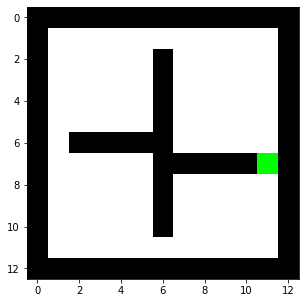

In [11]:
option = 2
# Simulation
observation = env.reset(57)
viz.resetMap(phi)

option = policy_over_options.sample(phi)
action = options[option].sample(phi)

for step in range(args.nsteps):
    observation, reward, done, _ = env.step(action)
    phi = features(observation)

    #render
    clear_output(wait=True)
    viz.showMap(phi, option)

    if options[option].terminate(phi):
        option = policy_over_options.sample(phi)

    action = options[option].sample(phi)

    if done:
        break

## Display action and option preference in each state

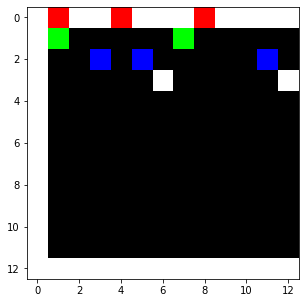

In [5]:
# Display option preference
viz.showPref(policy_over_options.weightsP)

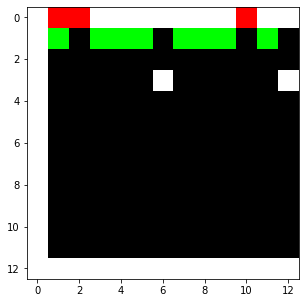

In [7]:
opt = 0
# Display action preference for opt
viz.showPref(options[opt].weightsP)